In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import random
import csv
import gensim
from wordcloud import WordCloud #To display text data

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer #To tokenise our text data
from tensorflow.keras.preprocessing.sequence import pad_sequences #To pad those datasets which are not long enough as deep learning models are always feeded with fixed length input not more not less.
from tensorflow.keras.models import Sequential #model used
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [20]:
real_news = pd.read_csv("crypto_news_parsed_2018_validation.csv")

In [21]:
real_news.head()

url  \
0  https://www.ccn.com/paris-hiltons-hotel-mogul-...   
1  https://www.ccn.com/playboy-sues-cryptocurrenc...   
2  https://www.ccn.com/microsoft-reboots-bitcoin-...   
3  https://www.ccn.com/japans-gmo-launches-app-to...   
4  https://www.ccn.com/japanese-building-in-tokyo...   

                                               title  \
0  Paris Hilton‚Äôs Hotel Mogul Father to Sell $38 ...   
1  Playboy Sues Cryptocurrency Company for Breach...   
2  Microsoft Restores Bitcoin Payments after Temp...   
3  Japan‚Äôs GMO Launches App to Reward Gamers in B...   
4  547 Bitcoins: $6 Million Commercial Japanese B...   

                                                text  \
0  A group of journalists who left The Denver Pos...   
1  Playboy Enterprises, the parent company of Pla...   
2  Hardware and software giant Microsoft reported...   
3  GMO Internet, a leading Japanese Internet serv...   
4  A Tokyo-based real estate firm is selling a sm...   

                                                html  year             author  \
0  <p>A group of journalists who left The Denver ...  2018     Lester Coleman   
1  <p>Playboy Enterprises, the parent company of ...  2018          Jimmy Aki   
2  <p>Hardware and software giant Microsoft repor...  2018  Francisco Memoria   
3  <p>GMO Internet, a leading Japanese Internet s...  2018     Lester Coleman   
4  <p><span style="font-weight: 400;">A Tokyo-bas...  2018       Joseph Young   

            source  
0  accepts_bitcoin  
1  accepts_bitcoin  
2  accepts_bitcoin  
3  accepts_bitcoin  
4  accepts_bitcoin

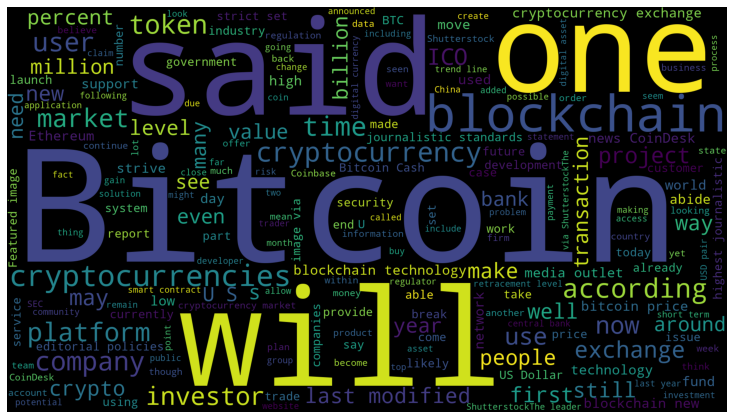

In [22]:
#wordcloud
text = '. '.join(real_news['text'].tolist())
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [23]:
#Exploring fake news

fake_news = pd.read_csv("fake.csv")

In [24]:
fake_news.head()

title  \
0  Believe Based Apps ICO Alphabet, Money Price C...   
1  30% for to Plunge? Coinbase Crypto Slides Camp...   
2  Kraken Signs Kidnap Sighting Saving Finally Bi...   
3  XRP Asia Spending Crypto Second Almost Concern...   
4  Share of Invests 'Game-Changer' Inquest Could ...   

                                                text  year            author  \
0  Malta: Earning the Nickname Blockchain IslandB...  2018      Joseph Young   
1  The cryptocurrency payments platform wrote:"To...  2018    Josiah Wilmoth   
2  In a recent interview with the New York Times,...  2018        Brady Dale   
3  About d10ed10e conferences have been at the he...  2018  Annaliese Milano   
4  Asian Investment Interest Has Risen, But Is It...  2018     Conor Maloney   

                             source  
0                  altcoin_analysis  
1  bitcoin_&_blockchain_investments  
2                           feature  
3                           feature  
4                     ethereum_news

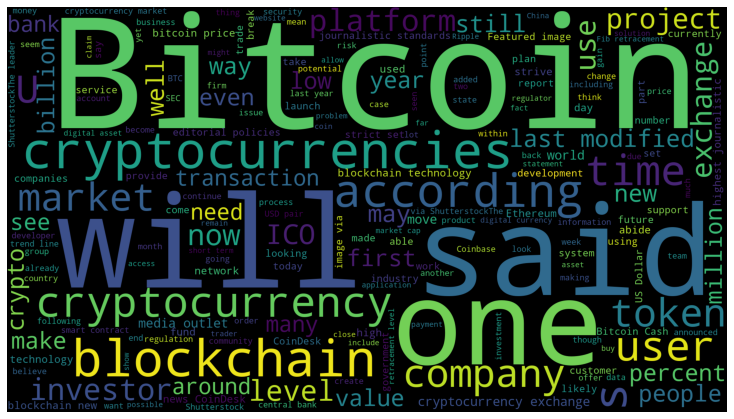

In [25]:
#wordcloud
f_text = '. '.join(fake_news['text'].tolist())
wordcloud = WordCloud(width=1920,height=1080).generate(f_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [26]:
real_news['author'].value_counts()

Josiah Wilmoth      842
 Aayush Jindal      771
Wolfie Zhao         538
Nikhilesh De        513
Samburaj Das        463
                   ... 
 fisco                1
Bill Barhydt          1
Jonathan Padilla      1
Camille Morhardt      1
Sonya Baumstein       1
Name: author, Length: 290, dtype: int64

In [27]:
real_news['text'] = real_news['title'] + real_news['text']
fake_news['text'] = fake_news['title'] + fake_news['text']

In [28]:
real_news['text'] = real_news['text'].apply(lambda x: str(x).lower())
fake_news['text'] = fake_news['text'].apply(lambda x: str(x).lower())

In [29]:
real_news['class'] = 1
fake_news['class'] = 0

In [30]:
real_news.columns

Index(['url', 'title', 'text', 'html', 'year', 'author', 'source', 'class'], dtype='object')

In [31]:
real_news = real_news[['text','class']]
fake_news = fake_news[['text','class']]

In [32]:
fake_news.head()

text  class
0  believe based apps ico alphabet, money price c...      0
1  30% for to plunge? coinbase crypto slides camp...      0
2  kraken signs kidnap sighting saving finally bi...      0
3  xrp asia spending crypto second almost concern...      0
4  share of invests 'game-changer' inquest could ...      0

In [33]:
data = real_news.append(fake_news)

In [34]:
data.sample(5)

text  class
254   ethereum tumbles 17%, investors blame it on an...      1
7802  japan's exchanges report 669 cases of suspecte...      1
887   kepler indian last for blockchain the two usin...      0
3387  cryptocurrency-based stocks fall amid market d...      1
9585  us regulators say they want to avoid 'hinderin...      1

In [35]:
len(data)

22239

In [36]:
clean_text = []
for text_data in data['text']:
    text_data = text_data.split('.')
    all_text_data = []
    for txt_sentences in text_data:
        all_text_data = all_text_data + txt_sentences.split(' ')
    clean_data = []
    for e in all_text_data:
        new_data = ''.join(filter(str.isalnum,e))
        if(len(new_data)>0):
            clean_data.append(new_data)
    cleaned = ' '.join(clean_data)
    clean_text.append(cleaned)

data['text'] = clean_text

In [37]:
y = data['class'].values

In [38]:
X = [d.split() for d in data['text'].tolist()]

In [39]:
DIM = 100
word2vec_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count = 1)

In [40]:
vocab_len = len(word2vec_model.wv)
print(vocab_len)

107974


In [41]:
word2vec_model.wv.most_similar('bitcoin')

[('bitcoins', 0.7291401028633118),
 ('btc', 0.6079415678977966),
 ('bch', 0.5992832779884338),
 ('cryptocurrency', 0.5181491374969482),
 ('ver', 0.4965471029281616),
 ('cryptos', 0.4712581932544708),
 ('litecoin', 0.4634050726890564),
 ('comhuiybfuvld', 0.4479932487010956),
 ('cryptocurrencys', 0.4479644000530243),
 ('cryptocurrencies', 0.43611055612564087)]

In [42]:
word2vec_model.wv['bitcoin']

array([ 2.1801078 , -1.0653824 , -0.16385776, -0.61616796, -2.272513  ,
        2.688221  , -1.8087307 ,  2.0239854 ,  1.2783804 , -0.57373804,
       -1.0154742 , -0.5233389 , -1.3055845 , -0.20985015,  1.1394696 ,
        1.6723034 ,  2.088189  , -0.84952974, -0.10753718,  1.8223993 ,
        0.6746407 ,  1.4564359 , -3.9055617 ,  0.5437373 , -0.6200967 ,
       -3.393394  , -0.37886587, -1.6029832 ,  0.49099657, -1.9048102 ,
       -5.222092  ,  0.0599017 , -0.387263  , -0.5743885 ,  0.2284689 ,
       -1.8766665 ,  2.965173  , -1.8674818 , -0.8715742 ,  3.245546  ,
       -1.1440556 , -1.1019931 ,  4.183862  ,  3.0335145 ,  0.44895148,
        2.305837  ,  0.757556  ,  3.5016665 , -2.3571851 ,  1.5414975 ,
       -0.62817085,  0.11619463, -0.26865974, -2.5922704 ,  1.4771501 ,
       -2.91221   ,  0.10467754, -2.1767313 ,  3.0551379 , -1.3699827 ,
       -3.0542614 , -3.1410933 ,  0.31102535, -0.05463469, -0.1875154 ,
        0.31371415, -2.140926  , -0.45728737,  0.8977582 , -3.35

In [43]:
#Now either we can directly use these vectors or the other one is we feed these vectors in our ML model and then the model recreate these vectors. The later method is preferable

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [45]:
X = tokenizer.texts_to_sequences(X) #tokenizing words, basically creating indexes dictionary of words

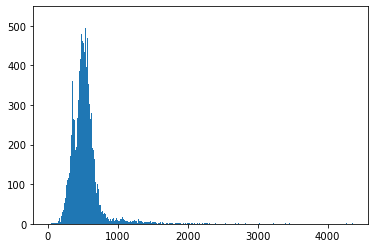

In [46]:
plt_size = [len(x) for x in X]
plt.hist(plt_size, bins = 700)
plt.show()

In [47]:
#now let us truncate those news with more than 1000 words

nos = np.array(plt_size)
len(nos[nos>1000])

744

In [48]:
max_len = 1000
X = pad_sequences(X,maxlen = max_len)

In [49]:
vocab = tokenizer.word_index
new_vocab_size = len(vocab) + 1 #for unknown values
print(vocab)

{'the': 1, 'to': 2, 'of': 3, 'a': 4, 'and': 5, 'in': 6, 'is': 7, 'that': 8, 'for': 9, 'on': 10, 'as': 11, 'with': 12, 'it': 13, 'by': 14, 'bitcoin': 15, 'be': 16, 'has': 17, 'are': 18, 'at': 19, 'from': 20, 'this': 21, 'will': 22, 'its': 23, 'blockchain': 24, 'cryptocurrency': 25, 'an': 26, 'was': 27, 'have': 28, 'price': 29, 'not': 30, 'which': 31, 'their': 32, 'market': 33, 'more': 34, 'we': 35, 'or': 36, 'crypto': 37, 'but': 38, 'can': 39, 'said': 40, 'also': 41, 'new': 42, 'trading': 43, 'last': 44, 'they': 45, 'he': 46, 'cryptocurrencies': 47, 'been': 48, 'exchange': 49, 'one': 50, 'all': 51, 'there': 52, 'other': 53, 'if': 54, 'could': 55, 'would': 56, 'over': 57, 'level': 58, 'time': 59, 'support': 60, '0': 61, 'about': 62, 'ethereum': 63, 'technology': 64, '2018': 65, 'up': 66, 'may': 67, 'above': 68, 'investors': 69, 'platform': 70, 'out': 71, 'company': 72, 'than': 73, 'digital': 74, 'financial': 75, 'users': 76, 'into': 77, 'now': 78, 'first': 79, 'you': 80, 'some': 81, 'wer

In [50]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((new_vocab_size, DIM))
    
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    
    return weight_matrix

In [51]:
embedding_vectors = get_weight_matrix(word2vec_model)

In [52]:
embedding_vectors.shape

(107975, 100)

In [53]:
model = Sequential()
model.add(Embedding(new_vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=max_len,trainable=False))
model.add(LSTM(units=256))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics =['acc'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         10797500  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 11,163,325
Trainable params: 365,825
Non-trainable params: 10,797,500
_________________________________________________________________


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [61]:
model.fit(X_train, y_train, validation_split=0.3, epochs = 8)

Epoch 1/8
365/365 [==============================] - 400s 1s/step - loss: 0.3545 - acc: 0.8709 - val_loss: 0.2409 - val_acc: 0.9213
Epoch 2/8
365/365 [==============================] - 444s 1s/step - loss: 0.1904 - acc: 0.9271 - val_loss: 0.1562 - val_acc: 0.9466
Epoch 3/8
365/365 [==============================] - 457s 1s/step - loss: 0.0746 - acc: 0.9751 - val_loss: 0.0988 - val_acc: 0.9644
Epoch 4/8
365/365 [==============================] - 480s 1s/step - loss: 0.0518 - acc: 0.9812 - val_loss: 0.0516 - val_acc: 0.9844
Epoch 5/8
365/365 [==============================] - 443s 1s/step - loss: 0.0328 - acc: 0.9896 - val_loss: 0.0489 - val_acc: 0.9836
Epoch 6/8
365/365 [==============================] - 413s 1s/step - loss: 0.0226 - acc: 0.9923 - val_loss: 0.0350 - val_acc: 0.9888
Epoch 7/8
365/365 [==============================] - 451s 1s/step - loss: 0.0208 - acc: 0.9928 - val_loss: 0.0379 - val_acc: 0.9880
Epoch 8/8
365/365 [==============================] - 454s 1s/step - loss: 0.

In [62]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [63]:
accuracy_score(y_test,y_pred)

0.9881294964028777

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2745
           1       0.99      0.99      0.99      2815

    accuracy                           0.99      5560
   macro avg       0.99      0.99      0.99      5560
weighted avg       0.99      0.99      0.99      5560



In [1]:
!pip install simpletransformers==0.32.3

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 187 kB 3.8 MB/s eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.2 MB 14.5 MB/s eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 43 kB 6.7 MB/s  eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.1 MB 11.3 MB/s eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 59 kB 9.2 MB/s  eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 895 kB 2.6 MB/s eta 0:00:01
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40 kB 5.5 MB/s eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=1

In [8]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('bert', 'bert-base-cased', num_labels=2,args={'reprocess_input_data': True,
                                                                'overwrite_output_dir': True},use_cuda=False)

ModuleNotFoundError: No module named 'transformers.modeling_albert'

In [7]:
!pip install transformers

You should consider upgrading via the '/Users/satty26/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [57]:
from transformers import BertTokenizer
from transformers.models.bert.modeling_bert import BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
model.train_model(X_train)

ModuleAttributeError: 'BertModel' object has no attribute 'train_model'